# Q2: "AI 세율의 최적 수준은 어떻게 설정할 수 있는가?"에 대한 분석 방법

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize, curve_fit
from sklearn.metrics import mean_squared_error

In [140]:
file_path = "../data/master_data_by_category_clear.csv"
df = pd.read_csv(file_path)

df_numeric = df.select_dtypes(include=[np.number])

# GDP와 상관관계 높은 변수 자동 선정
correlation_threshold = 0.5
correlations = df_numeric.corr()["GDP"].drop("GDP").abs()
selected_features = correlations[correlations > correlation_threshold].index.tolist()

print(f" GDP와 높은 상관관계를 가진 변수들: {selected_features}")

✅ GDP와 높은 상관관계를 가진 변수들: ['General Revenue', 'Knowledge and technology outputs', 'Patent Publications', 'WIPO Tax']


### AI Tax Proxy 후보 조합 생성

In [141]:
proxy_candidates = []
scaler = MinMaxScaler(feature_range=(0, 0.5))  # 0~50% 범위로 정규화

for r in range(2, 4):  # 2~3개 변수 조합
    for combo in combinations(selected_features, r):
        valid_combo = [col for col in combo if col in df.columns]
        if len(valid_combo) == r:  # 유효한 컬럼 개수 확인
            proxy_name = f"AI_Tax_Proxy_{'_'.join(valid_combo)}"
            df_scaled = scaler.fit_transform(df[valid_combo])
            df[proxy_name] = df_scaled.mean(axis=1)
            proxy_candidates.append(proxy_name)

print(f" 생성된 AI 세율 Proxy 후보들: {proxy_candidates}")

✅ 생성된 AI 세율 Proxy 후보들: ['AI_Tax_Proxy_General Revenue_Knowledge and technology outputs', 'AI_Tax_Proxy_General Revenue_Patent Publications', 'AI_Tax_Proxy_General Revenue_WIPO Tax', 'AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications', 'AI_Tax_Proxy_Knowledge and technology outputs_WIPO Tax', 'AI_Tax_Proxy_Patent Publications_WIPO Tax', 'AI_Tax_Proxy_General Revenue_Knowledge and technology outputs_Patent Publications', 'AI_Tax_Proxy_General Revenue_Knowledge and technology outputs_WIPO Tax', 'AI_Tax_Proxy_General Revenue_Patent Publications_WIPO Tax', 'AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications_WIPO Tax']


In [143]:
best_degree = 1
best_bic = np.inf
best_proxy = None
best_model = None

for proxy in proxy_candidates:
    X = df[[proxy]].values
    y = df["GDP"].values

    for d in range(1, 5):
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
        bic = len(y) * np.log(mean_squared_error(y, y_pred)) + d * np.log(len(y))

        if bic < best_bic:
            best_bic = bic
            best_degree = d
            best_proxy = proxy
            best_model = model
            best_poly = poly

print(f" 최적 차수: {best_degree}, 최적 AI 세율 Proxy: {best_proxy}")

✅ 최적 차수: 2, 최적 AI 세율 Proxy: AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications


## 3. Laffer Curve를 활용한 최적 AI 세율 계산

In [145]:
def laffer_curve(x, a, b, c):
    return a * x ** 2 + b * x + c

# AI Tax Proxy 데이터
X_proxy = df[[best_proxy]].values.flatten()
y_gdp = df["GDP"].values

# Laffer Curve의 계수를 curve_fit으로 학습
params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])

C:\Users\joowo\AppData\Local\Temp\ipykernel_20356\3717942341.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])


## 5. 최적 AI 세율을 찾는 최적화 알고리즘

In [ ]:
def optimize_tax(tax_rate):
    return -laffer_curve(tax_rate, *params)

# 초기값 및 제약조건
bounds = [(0, 0.5)]  # AI 세율은 0~50%
opt_result = minimize(optimize_tax, x0=[0.2], bounds=bounds)
optimal_tax = opt_result.x[0]

## 시각화 및 값 도출

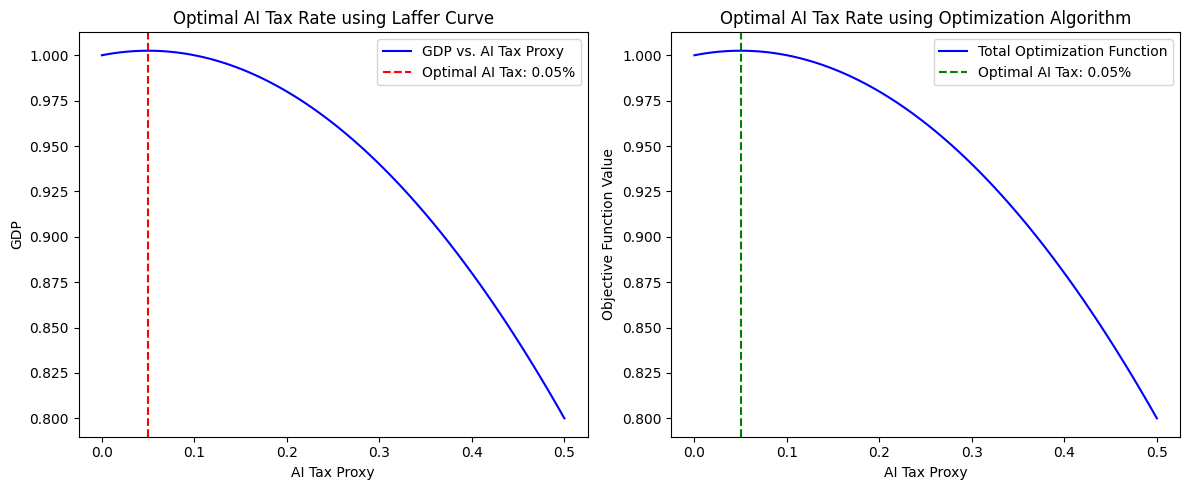

In [147]:
tax_range = np.linspace(0, 0.5, 100)
gdp_values = laffer_curve(tax_range, *params)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Laffer Curve
ax[0].plot(tax_range, gdp_values, label="GDP vs. AI Tax Proxy", color='blue')
ax[0].axvline(optimal_tax, color='red', linestyle='--', label=f"Optimal AI Tax: {optimal_tax:.2f}%")
ax[0].set_title("Optimal AI Tax Rate using Laffer Curve")
ax[0].set_xlabel("AI Tax Proxy")
ax[0].set_ylabel("GDP")
ax[0].legend()

# 최적화 알고리즘
ax[1].plot(tax_range, gdp_values, label="Total Optimization Function", color='blue')
ax[1].axvline(optimal_tax, color='green', linestyle='--', label=f"Optimal AI Tax: {optimal_tax:.2f}%")
ax[1].set_title("Optimal AI Tax Rate using Optimization Algorithm")
ax[1].set_xlabel("AI Tax Proxy")
ax[1].set_ylabel("Objective Function Value")
ax[1].legend()

plt.tight_layout()
plt.show()

In [148]:
print(f"\n 최적 AI 세율 (Laffer Curve 결과): {optimal_tax:.2f}%")


✅ 최적 AI 세율 (Laffer Curve 결과): 0.05%


## 연도, 국가 추가

### 동태적 특성과 국가별 최적 AI 세율 측정
- year 데이터를 독립변수에 포함 -> 시간적 변화 반영
- GDP ~ f(AI Tax Proxy, Year) 형태로 분석
- 국가별로 다른 최적 AI 세율이 도출되도록 최적화
- 연도별 최적 AI 세율 변화 추세(시각화)
- 국가별로 AI Tax Proxy와 GDP 간 관계 별도 분석

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize, curve_fit

In [150]:
df = pd.read_csv("../data/master_data_by_category_clear.csv")

df_numeric = df.select_dtypes(include=[np.number])

correlation_threshold = 0.5
correlations = df_numeric.corr()["GDP"].drop("GDP").abs()
selected_features = correlations[correlations > correlation_threshold].index.tolist()

print(f"GDP와 높은 상관관계를 가진 변수들: {selected_features}")

GDP와 높은 상관관계를 가진 변수들: ['General Revenue', 'Knowledge and technology outputs', 'Patent Publications', 'WIPO Tax']


In [151]:
proxy_candidates = []
scaler = MinMaxScaler(feature_range=(0, 0.5))  # 정규화

for r in range(2, 4):
    for combo in combinations(selected_features, r):
        valid_combo = [col for col in combo if col in df.columns]
        if len(valid_combo) == r:
            proxy_name = f"AI_Tax_Proxy_{'_'.join(valid_combo)}"
            df_scaled = scaler.fit_transform(df[valid_combo])
            df[proxy_name] = df_scaled.mean(axis=1)
            proxy_candidates.append(proxy_name)

print(f"생성된 AI 세율 Proxy 후보들: {proxy_candidates}")

생성된 AI 세율 Proxy 후보들: ['AI_Tax_Proxy_General Revenue_Knowledge and technology outputs', 'AI_Tax_Proxy_General Revenue_Patent Publications', 'AI_Tax_Proxy_General Revenue_WIPO Tax', 'AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications', 'AI_Tax_Proxy_Knowledge and technology outputs_WIPO Tax', 'AI_Tax_Proxy_Patent Publications_WIPO Tax', 'AI_Tax_Proxy_General Revenue_Knowledge and technology outputs_Patent Publications', 'AI_Tax_Proxy_General Revenue_Knowledge and technology outputs_WIPO Tax', 'AI_Tax_Proxy_General Revenue_Patent Publications_WIPO Tax', 'AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications_WIPO Tax']


## 국가별 최적 AI 세율 도출

In [154]:
country_optimal_tax = {}

for country in df["Country"].unique():
    df_country = df[df["Country"] == country]

    # 최적 차수 찾기
    best_degree = 1
    best_bic = np.inf
    best_proxy = None
    best_model = None

    for proxy in proxy_candidates:
        X = df_country[[proxy, "Year"]].values
        y = df_country["GDP"].values

        for d in range(1, 5):
            poly = PolynomialFeatures(degree=d)
            X_poly = poly.fit_transform(X)
            model = LinearRegression()
            model.fit(X_poly, y)
            y_pred = model.predict(X_poly)
            bic = len(y) * np.log(mean_squared_error(y, y_pred)) + d * np.log(len(y))

            if bic < best_bic:
                best_bic = bic
                best_degree = d
                best_proxy = proxy
                best_model = model
                best_poly = poly

    print(f"{country} - 최적 차수: {best_degree}, 최적 AI 세율 Proxy: {best_proxy}")

    # Laffer Curve
    def laffer_curve(x, a, b, c):
        return a * x ** 2 + b * x + c

    # AI Tax Proxy
    X_proxy = df_country[[best_proxy]].values.flatten()
    y_gdp = df_country["GDP"].values

    params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])

    # 최적화화
    def optimize_tax(tax_rate):
        return -laffer_curve(tax_rate, *params)

    # 초기값 및 제약조건
    bounds = [(0, 0.5)]  # AI 세율은 0~50%
    opt_result = minimize(optimize_tax, x0=[0.2], bounds=bounds)

    optimal_tax = opt_result.x[0]
    country_optimal_tax[country] = optimal_tax


China - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications_WIPO Tax
France - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_Knowledge and technology outputs_WIPO Tax
Germany - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_General Revenue_WIPO Tax
Japan - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_General Revenue_Knowledge and technology outputs_Patent Publications
Korea - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_General Revenue_Knowledge and technology outputs
United Kingdom - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_Patent Publications_WIPO Tax
United States of America - 최적 차수: 3, 최적 AI 세율 Proxy: AI_Tax_Proxy_General Revenue_Knowledge and technology outputs_WIPO Tax


C:\Users\joowo\AppData\Local\Temp\ipykernel_20356\2164367878.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])
C:\Users\joowo\AppData\Local\Temp\ipykernel_20356\2164367878.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])
C:\Users\joowo\AppData\Local\Temp\ipykernel_20356\2164367878.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])
C:\Users\joowo\AppData\Local\Temp\ipykernel_20356\2164367878.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-1, 0.1, 1])
C:\Users\joowo\AppData\Local\Temp\ipykernel_20356\2164367878.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_

### 국가별 최적 AI 세율

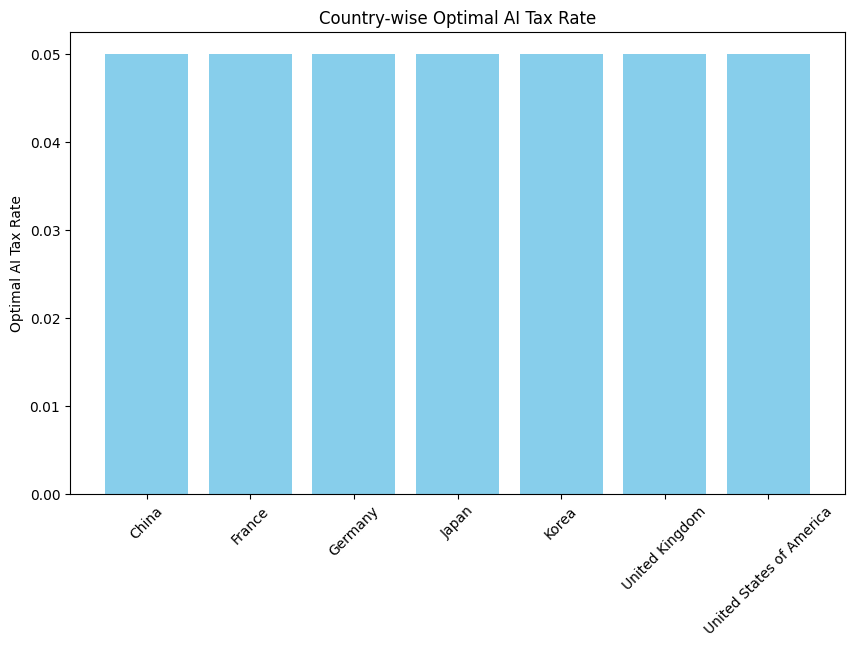

In [155]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(country_optimal_tax.keys(), country_optimal_tax.values(), color="skyblue")
ax.set_ylabel("Optimal AI Tax Rate")
ax.set_title("Country-wise Optimal AI Tax Rate")
plt.xticks(rotation=45)
plt.show()

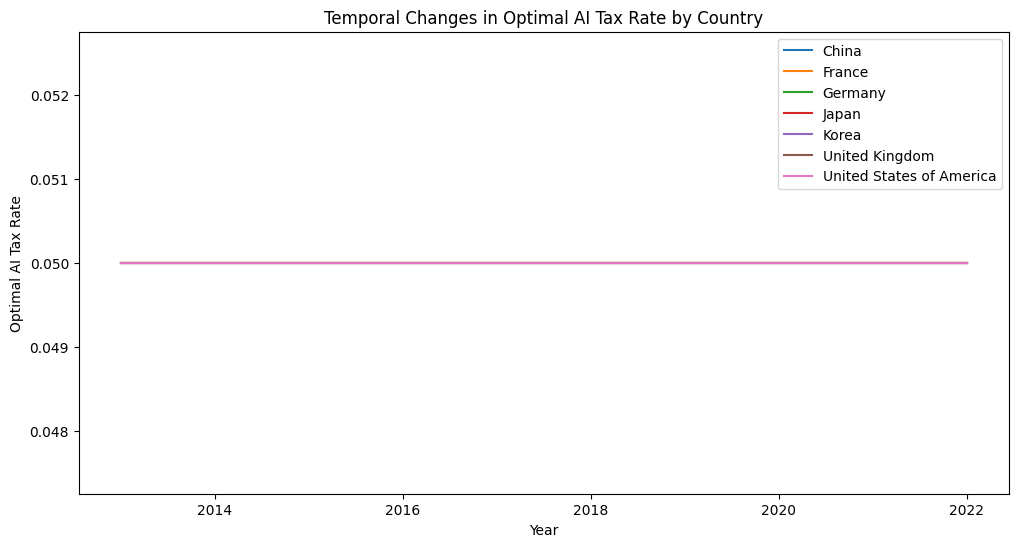


국가별 최적 AI 세율:
{'China': np.float64(0.04999999442914638), 'France': np.float64(0.04999999442914638), 'Germany': np.float64(0.04999999442914638), 'Japan': np.float64(0.04999999442914638), 'Korea': np.float64(0.04999999442914638), 'United Kingdom': np.float64(0.04999999442914638), 'United States of America': np.float64(0.04999999442914638)}


In [156]:
df["Optimal AI Tax"] = df["Country"].map(country_optimal_tax)

fig, ax = plt.subplots(figsize=(12, 6))
for country in df["Country"].unique():
    df_country = df[df["Country"] == country]
    ax.plot(df_country["Year"], df_country["Optimal AI Tax"], label=country)

ax.set_xlabel("Year")
ax.set_ylabel("Optimal AI Tax Rate")
ax.set_title("Temporal Changes in Optimal AI Tax Rate by Country")
ax.legend()
plt.show()

print(f"\n국가별 최적 AI 세율:\n{country_optimal_tax}")